In [2]:
# dir set

import os
import matplotlib.pyplot as plt

os.chdir("/content/drive/MyDrive/ddpm_implementation")
PATH = "afhq/train/cat"
names = os.listdir(PATH)

In [3]:
# dataset

import torch
import torch.nn as nn
import torchvision
import math
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])


class CustomDataset(Dataset):
    def __init__(self, names, transform=None):
        self.data = [Image.open(os.path.join(PATH, name)) for name in names]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

trainset = CustomDataset(names, transform)
dataloader = DataLoader(trainset, batch_size=16, shuffle = True)

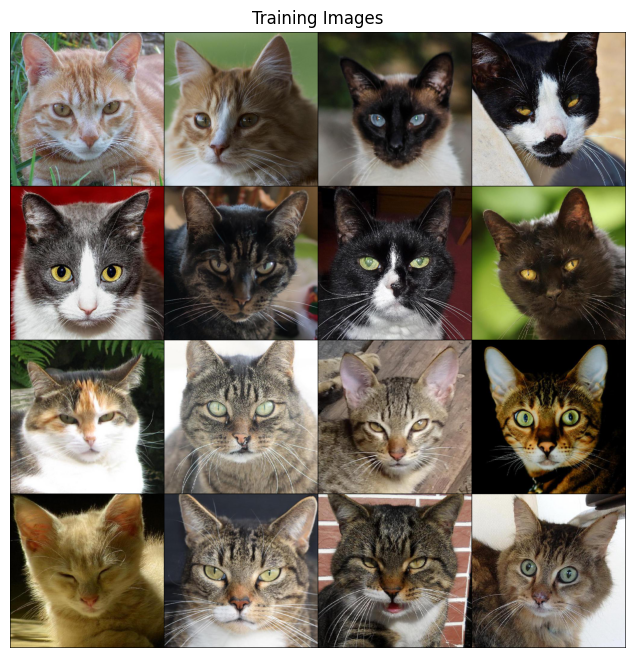

In [4]:
# data configuration

import numpy as np
import torchvision.utils as vutils

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch, padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

In [5]:
# beta scheduling (linear, cosine)

T = 1000

lin_betas = torch.linspace(10e-4, 0.02, T)
lin_alphas = 1 - lin_betas
s = torch.sqrt(lin_betas[0])

def f_t(t):
  return torch.cos((t/T + s) / (1 + s) * torch.pi/2) ** 2

cos_pi_alphas = torch.tensor([f_t(t) / f_t(0) for t in range(1, T+1)]) 
cos_pi_alphas_t_minus = torch.tensor([f_t(t) / f_t(0) for t in range(0, T)])
cos_betas = 1 - cos_pi_alphas / cos_pi_alphas_t_minus
cos_posterial_betas = (1 - cos_pi_alphas_t_minus) / (1 - cos_pi_alphas) * (cos_betas)

lin_pi_betas = torch.cumprod(lin_betas, axis=0)
lin_pi_alphas = torch.cumprod(lin_alphas, axis=0)
lin_pi_alphas_t_minus = torch.cat((torch.tensor([1]), lin_pi_alphas[:-1]), dim=0)
lin_posterior_betas = (1 - lin_pi_alphas_t_minus) / (1 - lin_pi_alphas) * lin_betas

In [6]:
def get_diffused_image(x, t, cos_schedule = True):
  if cos_schedule:
    return torch.sqrt(cos_pi_alphas[t]) * x + torch.sqrt(1 - cos_pi_alphas[t]) * torch.randn_like(x)
  else:
    return torch.sqrt(lin_pi_alphas[t]) * x + torch.sqrt(1 - lin_pi_alphas[t]) * torch.randn_like(x)

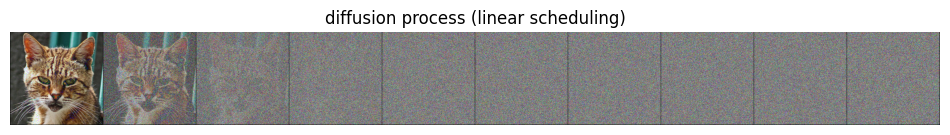

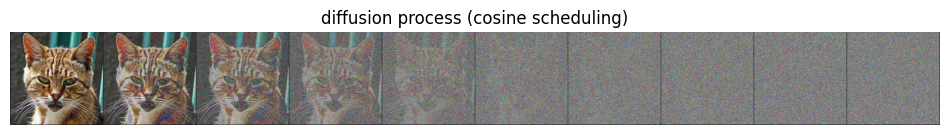

In [7]:
# diffusion visualization

reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
image = next(iter(dataloader))[0]
images = [reverse_transforms(get_diffused_image(image, t_i)) for t_i in range(0, 1000, 100)]
tensor_list = [transforms.ToTensor()(image) for image in images]
minibatch = torch.stack(tensor_list)

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("diffusion process (linear scheduling)")
plt.imshow(np.transpose(vutils.make_grid(minibatch, nrow=10),(1,2,0)))

cos_schedule = True
images = [reverse_transforms(get_diffused_image(image, t_i, cos_schedule)) for t_i in range(0, 1000, 100)]
tensor_list = [transforms.ToTensor()(image) for image in images]
minibatch = torch.stack(tensor_list)

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("diffusion process (cosine scheduling)")
plt.imshow(np.transpose(vutils.make_grid(minibatch, nrow=10),(1,2,0)))

plt.show()

In [16]:
class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False, n_head=4, head_dim=32):
    super().__init__()
    self.in_ch = in_ch
    self.out_ch = out_ch
    self.up = up
    self.time_emb_dim = time_emb_dim
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)
    
    if up == False:
      self.attn = nn.Identity()
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1)
      self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1)
      self.transform = nn.Identity()
    
    if up:
      self.attn = AttentionGate(2 * in_ch, n_head, head_dim)
      self.conv1 = nn.Conv2d(in_ch * 2, in_ch, 3, 1)
      self.conv2 = nn.Conv2d(in_ch, out_ch, 3, 1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)

    self.bn1 = nn.BatchNorm2d(in_ch)
    self.bn2 = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU()

  def forward(self, x, t):
      t = self.time_mlp(t)
      t = self.relu(t)
      t = t[(..., ) + (None, ) * 2]
      x = self.transform(x)
      h = self.attn(x)
      h = self.conv1(x)
      h = self.bn1(h)
      h = self.relu(h)
      h = x + t
      h = self.conv2(h)
      h = self.relu(h)
      h = self.bn2(h)
      return h
    
class PositionalEncoding(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    res = torch.zeros((len(time), self.dim))
    emb = 1 / torch.pow(10000, 2*torch.arange(int(self.dim/2))/self.dim)
    res[:, ::2] = torch.cos(time[:, None] * emb[None, :]) 
    res[:, 1::2] = torch.sin(time[:, None] * emb[None, :])
    return res

class AttentionGate(nn.Module):
  def __init__(self, n_channels, n_heads=4, head_dim=32):
    super().__init__()

  def forward(self, x):
    batch_size, n_channels, height, width = x.shape
    x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
    qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
    q, k, v = torch.chunk(qkv, 3, dim=-1)
    attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
    attn = attn.softmax(dim=2)
    res = torch.einsum('bijh,bjhd->bihd', attn, v)
    res = res.view(batch_size, -1, self.n_heads * self.d_k)
    res = self.output(res)
    res += x
    res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
    return res

class Unet(nn.Module):
  def __init__(self, time_emb_dim=32, n_head=4, head_dim=32):
    super().__init__()
    in_dim = 3
    out_dim = 6
    down_ch = (64, 128, 256, 512)
    up_ch = (512, 256, 128, 64)
    self.time_emb_dim = time_emb_dim
    self.time_mlp = nn.Sequential(
                PositionalEncoding(self.time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
    self.conv0 = nn.Conv2d(in_dim, down_ch[0], 3, 1)
    self.downs = nn.ModuleList(Block(down_ch[i], down_ch[i+1], self.time_emb_dim) for i in range(len(down_ch) - 1))
    self.ups = nn.ModuleList(Block(up_ch[i], up_ch[i+1], self.time_emb_dim, up=True, n_head=n_head, head_dim=head_dim) for i in range(len(up_ch) - 1))
    self.mid_block = nn.Sequential(nn.Conv2d(down_ch[-1], down_ch[-1] * 2, 3, 1),
                                   nn.ReLU(),
                                   nn.Conv2d(down_ch[-1] * 2, down_ch[-1], 3, 1),
                                   nn.ReLU())
    self.down_sample = nn.MaxPool2d(2)
    self.output = nn.Sequential(nn.Conv2d(up_ch[-1], up_ch[-1], 1),
                                nn.ReLU(),
                                nn.Conv2d(up_ch[-1], out_dim, 1)
                                )

  def forward(self, x, T):
    t = self.time_mlp(T)
    x = self.conv0(x)
    residual = []
    for down in self.downs:
      x = down(x, t)
      residual.append(x)
      self.down_sample(x)

    x = self.mid_block(x)

    for up in self.ups:
      res_x = residual.pop()
      x = torch.cat((x, res_x), dim=1)
      x = up(x, t)
    return self.output(x)

time_emb_dim = 32
attn_head=4
attn_dim=32
model = Unet(time_emb_dim, attn_head, attn_dim)
model

Unet(
  (time_mlp): Sequential(
    (0): PositionalEncoding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (attn): Identity()
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (transform): Identity()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (attn): Identity()
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (transform): Identity()
      (bn1):

In [21]:
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence

def get_loss(model, x_0, t, lambda_=0.001, loss_type='l2'):
  noised= get_diffused_image(x_0, t, cos_schedule=True)
  noise = torch.randn_like(x_0)
  pred = model(noised, t)
  pred_noise = pred[:, :3, :, :]
  v = pred[:, 3:, :, :]
  v = torch.clamp(v, min=0.0, max=1.0)

  gt_mean = (torch.sqrt(cos_pi_alphas_t_minus[t]) * cos_betas[t]) / (1 - cos_pi_alphas[t]) * x_0 + (torch.sqrt(1 - cos_betas[t]) *(1 - cos_pi_alphas_t_minus[t])) / 1 - cos_pi_alphas[t] * noised
  gt_var = cos_posterial_betas

  pred_var = torch.exp(v * torch.log(cos_betas[t]) + (1 - v) * torch.log(cos_posterial_betas[t]))
  pred_mean = 1 / torch.sqrt(1 - cos_betas[t]) * (noised - cos_betas[t] / torch.sqrt(1 - cos_pi_alphas[t]) * pred_noise)

  gt_normal = Normal(gt_mean, gt_var)
  pred_normal = Normal(pred_mean, pred_var)
  loss_kl = kl_divergence(gt_normal, pred_normal)

  if t not in [0, T-1]:
    if loss_type == 'l1':
      return F.l1_loss(noise, pred_noise) + lambda_ * loss_kl
    else:
      return F.mse_loss(noise, pred_noise) + lambda_ * loss_kl
  
  else:
    if loss_type == 'l1':
      return F.l1_loss(noise, pred_noise)
    else:
      return F.mse_loss(noise, pred_noise)


In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = cos_betas[t]
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(cos_pi_alphas_t_minus[t])
    sqrt_recip_alphas_t = torch.sqrt(1.0 / (1 - cos_betas[t]))
    
    pred_mean = 1 / torch.sqrt(1 - cos_betas[t]) * (noised - cos_betas[t] / torch.sqrt(1 - cos_pi_alphas[t]) * pred_noise)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()   

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()